# 04_backtesting_and_robustness

04 — Backtesting & Robustness (Costs, Turnover, Risk Metrics)
Goal: Compute portfolio performance for:

- Pure TA (pos_ta → equal-weight among active positions)
- Pure Fundamentals (w_fund)
- Hybrid (w_hybrid) Include transaction costs, turnover, and summary metrics. Save results to reports/.

### Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 150)

REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_PROCESSED = os.path.join(REPO_ROOT, "data", "processed")
REPORTS = os.path.join(REPO_ROOT, "reports")
os.makedirs(REPORTS, exist_ok=True)

signals_path = os.path.join(DATA_PROCESSED, "signals.parquet")
assert os.path.exists(signals_path), f"Missing {signals_path}. Run Notebook 03 first."

df = pd.read_parquet(signals_path)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["ticker","date"]).reset_index(drop=True)

df.head()


,date,ticker,adj_close,open,high,low,close,volume,ema5,ema20,stoch_k_14,stoch_d_14_3,is_doji,is_hammer,is_bull_engulf,is_bear_engulf,fundamental_score,value_score,quality_score,growth_score,income_score,sig_ta_entry,sig_ta_exit,pos_ta,sig_fund_select,w_fund,sig_hybrid_member,w_hybrid
0,2018-01-02,AAPL,40.341881,42.540001,43.075001,42.314999,43.064999,102223600,40.341881,40.341881,NaN,NaN,0,0,0,0,-1.28508,-3.297949,0.033329,-0.272519,-0.879593,0,0,0,0,0.0,0,0.0
1,2018-01-03,AAPL,40.334866,43.132500,43.637501,42.990002,43.057499,118071600,40.339542,40.341213,NaN,NaN,0,0,0,0,-1.28508,-3.297949,0.033329,-0.272519,-0.879593,0,1,0,0,0.0,0,0.0
2,2018-01-04,AAPL,40.522221,43.134998,43.367500,43.020000,43.257500,89738400,40.400435,40.358452,NaN,NaN,0,0,0,0,-1.28508,-3.297949,0.033329,-0.272519,-0.879593,0,0,0,0,0.0,0,0.0
3,2018-01-05,AAPL,40.983578,43.360001,43.842499,43.262501,43.750000,94640000,40.594816,40.417987,NaN,NaN,0,0,0,0,-1.28508,-3.297949,0.033329,-0.272519,-0.879593,0,0,0,0,0.0,0,0.0
4,2018-01-08,AAPL,40.831348,43.587502,43.902500,43.482498,43.587502,82271200,40.673660,40.457355,NaN,NaN,1,0,0,0,-1.28508,-3.297949,0.033329,-0.272519,-0.879593,0,0,0,0,0.0,0,0.0


### Compute returns per ticker



In [2]:
df["ret"] = df.groupby("ticker")["adj_close"].pct_change()
df["ret"] = df["ret"].fillna(0.0)

df[["date","ticker","adj_close","ret"]].head(10)


,date,ticker,adj_close,ret
0,2018-01-02,AAPL,40.341881,0.000000
1,2018-01-03,AAPL,40.334866,-0.000174
2,2018-01-04,AAPL,40.522221,0.004645
3,2018-01-05,AAPL,40.983578,0.011385
4,2018-01-08,AAPL,40.831348,-0.003714
5,2018-01-09,AAPL,40.826656,-0.000115
6,2018-01-10,AAPL,40.817303,-0.000229
7,2018-01-11,AAPL,41.049141,0.005680
8,2018-01-12,AAPL,41.473022,0.010326
9,2018-01-16,AAPL,41.262260,-0.005082


### Build TA weights (equal-weight among active TA positions)

In [3]:
# TA active membership
df["sig_ta_member"] = (df["pos_ta"] == 1).astype(int)

ta_count = df.groupby("date")["sig_ta_member"].transform("sum").replace(0, np.nan)
df["w_ta"] = np.where(df["sig_ta_member"] == 1, 1.0 / ta_count, 0.0)
df["w_ta"] = df["w_ta"].fillna(0.0)

# sanity
df.groupby("date")[["w_ta","w_fund","w_hybrid"]].sum().describe()


,w_ta,w_fund,w_hybrid
count,2009.000000,2009.0,2009.000000
mean,0.642111,1.0,0.441513
std,0.479499,0.0,0.496691
min,0.000000,1.0,0.000000
25%,0.000000,1.0,0.000000
50%,1.000000,1.0,0.000000
75%,1.000000,1.0,1.000000
max,1.000000,1.0,1.000000


### Portfolio returns (gross, before costs)

In [4]:
def portfolio_returns(df, weight_col, ret_col="ret"):
    return df.groupby("date").apply(lambda g: np.sum(g[weight_col].values * g[ret_col].values)).rename(f"port_{weight_col}")

port_ta = portfolio_returns(df, "w_ta")
port_fund = portfolio_returns(df, "w_fund")
port_hybrid = portfolio_returns(df, "w_hybrid")

ports = pd.concat([port_ta, port_fund, port_hybrid], axis=1).fillna(0.0)
ports.head()


/var/folders/jj/2s0kgvsj38d_st6w4xnsnfs80000gn/T/ipykernel_94171/3583088852.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("date").apply(lambda g: np.sum(g[weight_col].values * g[ret_col].values)).rename(f"port_{weight_col}")
/var/folders/jj/2s0kgvsj38d_st6w4xnsnfs80000gn/T/ipykernel_94171/3583088852.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("date").apply(lambda g: n

,port_w_ta,port_w_fund,port_w_hybrid
date,,,
2018-01-02,0.0,0.000000,0.0
2018-01-03,0.0,0.015763,0.0
2018-01-04,0.0,0.003492,0.0
2018-01-05,0.0,0.007437,0.0
2018-01-08,0.0,0.002354,0.0


### Turnover + transaction costs

0.5 × sum(|w_t - w_{t-1}|) across all tickers (standard convention).

In [5]:
def daily_turnover(df, weight_col):
    w = df.pivot(index="date", columns="ticker", values=weight_col).fillna(0.0)
    dw = w.diff().abs()
    # 0.5 factor avoids double counting buys+sells for a fully invested portfolio
    turnover = 0.5 * dw.sum(axis=1)
    return turnover.rename(f"turnover_{weight_col}")

turn_ta = daily_turnover(df, "w_ta")
turn_fund = daily_turnover(df, "w_fund")
turn_hybrid = daily_turnover(df, "w_hybrid")

turn = pd.concat([turn_ta, turn_fund, turn_hybrid], axis=1).fillna(0.0)
turn.head()


,turnover_w_ta,turnover_w_fund,turnover_w_hybrid
date,,,
2018-01-02,0.0,0.0,0.0
2018-01-03,0.0,0.0,0.0
2018-01-04,0.0,0.0,0.0
2018-01-05,0.0,0.0,0.0
2018-01-08,0.0,0.0,0.0


### Apply costs

Set cost assumptions (you can tune later):

5 bps (0.05%) per 1.0 turnover is a reasonable “simple model”

In [6]:
COST_BPS = 5  # 5 basis points per unit turnover
cost_rate = COST_BPS / 10000.0

ports_net = ports.copy()
ports_net["net_w_ta"] = ports["port_w_ta"] - cost_rate * turn["turnover_w_ta"]
ports_net["net_w_fund"] = ports["port_w_fund"] - cost_rate * turn["turnover_w_fund"]
ports_net["net_w_hybrid"] = ports["port_w_hybrid"] - cost_rate * turn["turnover_w_hybrid"]

ports_net = ports_net[["net_w_ta","net_w_fund","net_w_hybrid"]]
ports_net.head()


,net_w_ta,net_w_fund,net_w_hybrid
date,,,
2018-01-02,0.0,0.000000,0.0
2018-01-03,0.0,0.015763,0.0
2018-01-04,0.0,0.003492,0.0
2018-01-05,0.0,0.007437,0.0
2018-01-08,0.0,0.002354,0.0


### Performance metrics

In [7]:
TRADING_DAYS = 252

def max_drawdown(equity_curve):
    peak = equity_curve.cummax()
    dd = equity_curve / peak - 1.0
    return dd.min(), dd

def perf_stats(returns, name="strategy"):
    returns = returns.fillna(0.0)
    eq = (1.0 + returns).cumprod()
    total_return = eq.iloc[-1] - 1.0
    cagr = (eq.iloc[-1]) ** (TRADING_DAYS / len(eq)) - 1.0 if len(eq) > 0 else np.nan

    vol = returns.std() * np.sqrt(TRADING_DAYS)
    sharpe = (returns.mean() / returns.std()) * np.sqrt(TRADING_DAYS) if returns.std() != 0 else np.nan

    downside = returns[returns < 0].std() * np.sqrt(TRADING_DAYS)
    sortino = (returns.mean() / returns[returns < 0].std()) * np.sqrt(TRADING_DAYS) if returns[returns < 0].std() != 0 else np.nan

    mdd, dd_series = max_drawdown(eq)
    calmar = cagr / abs(mdd) if mdd != 0 else np.nan

    win_rate = (returns > 0).mean()

    return {
        "name": name,
        "total_return": total_return,
        "cagr": cagr,
        "volatility": vol,
        "sharpe": sharpe,
        "sortino": sortino,
        "max_drawdown": mdd,
        "calmar": calmar,
        "win_rate_daily": win_rate,
        "days": len(eq)
    }

stats = pd.DataFrame([
    perf_stats(ports_net["net_w_ta"], "TA (EMA5+Stoch+Candles)"),
    perf_stats(ports_net["net_w_fund"], "Fundamentals (Top-N Rank)"),
    perf_stats(ports_net["net_w_hybrid"], "Hybrid (Fund+TA timing)")
])

stats


,name,total_return,cagr,volatility,sharpe,sortino,max_drawdown,calmar,win_rate_daily,days
0,TA (EMA5+Stoch+Candles),52.191511,0.646198,0.139368,3.649288,4.896061,-0.072345,8.932226,0.404181,2009
1,Fundamentals (Top-N Rank),3.127154,0.194605,0.200348,0.988319,1.216905,-0.340355,0.571771,0.555998,2009
2,Hybrid (Fund+TA timing),15.870116,0.425359,0.133487,2.722907,3.085724,-0.067970,6.258081,0.271777,2009


### Equity curves

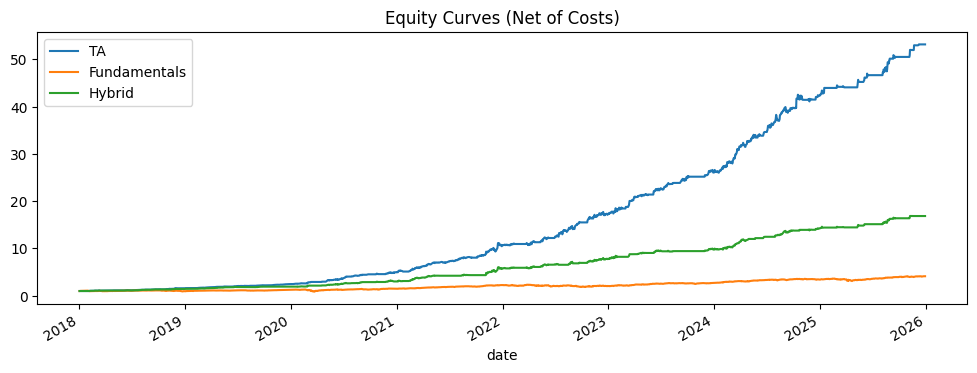

In [8]:
eq = pd.DataFrame({
    "TA": (1 + ports_net["net_w_ta"]).cumprod(),
    "Fundamentals": (1 + ports_net["net_w_fund"]).cumprod(),
    "Hybrid": (1 + ports_net["net_w_hybrid"]).cumprod()
})

eq.plot(figsize=(12,4), title="Equity Curves (Net of Costs)")
plt.show()


### Drawdowns

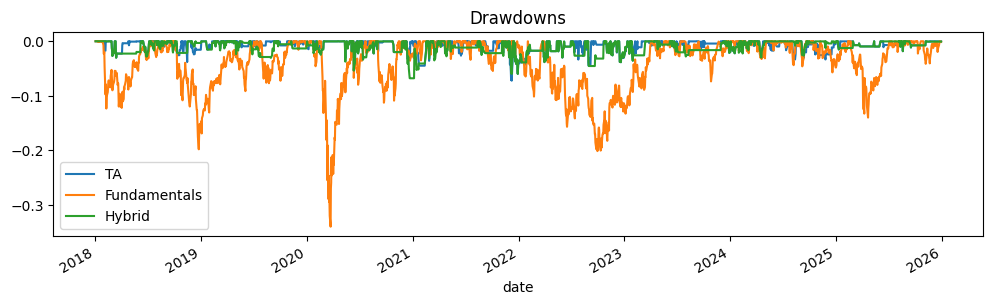

In [9]:
def drawdown_series(returns):
    eq = (1 + returns).cumprod()
    peak = eq.cummax()
    return eq/peak - 1

dd = pd.DataFrame({
    "TA": drawdown_series(ports_net["net_w_ta"]),
    "Fundamentals": drawdown_series(ports_net["net_w_fund"]),
    "Hybrid": drawdown_series(ports_net["net_w_hybrid"])
})

dd.plot(figsize=(12,3), title="Drawdowns")
plt.show()


### Robustness checks (simple but credible)

A) Parameter sensitivity: Stochastic oversold threshold

We’ll test a couple oversold thresholds quickly by filtering entries (approx).
This is not a full re-run of Notebook 03, but a quick sanity lens.

In [10]:
# Simple lens: how often signals trigger at different oversold thresholds?
k_prev = df.groupby("ticker")["stoch_k_14"].shift(1)
d_prev = df.groupby("ticker")["stoch_d_14_3"].shift(1)
k = df["stoch_k_14"]
d = df["stoch_d_14_3"]

stoch_cross_up = (k_prev < d_prev) & (k > d)
trend_ok = (df["adj_close"] > df["ema20"])
bull_candle = (df["is_hammer"] == 1) | (df["is_bull_engulf"] == 1)

thresholds = [10, 20, 30]
rows = []
for th in thresholds:
    entry = trend_ok & stoch_cross_up & (k_prev < th) & bull_candle
    rate = entry.groupby(df["date"]).sum().mean()  # avg signals per day
    rows.append({"oversold_threshold": th, "avg_entries_per_day": rate})

pd.DataFrame(rows)


,oversold_threshold,avg_entries_per_day
0,10,0.146839
1,20,0.159781
2,30,0.177700


B) Turnover summary (Code)

In [11]:
turn_summary = pd.DataFrame({
    "TA_avg_turnover": turn["turnover_w_ta"].mean(),
    "Fund_avg_turnover": turn["turnover_w_fund"].mean(),
    "Hybrid_avg_turnover": turn["turnover_w_hybrid"].mean(),
    "TA_median_turnover": turn["turnover_w_ta"].median(),
    "Fund_median_turnover": turn["turnover_w_fund"].median(),
    "Hybrid_median_turnover": turn["turnover_w_hybrid"].median()
}, index=[0])

turn_summary


,TA_avg_turnover,Fund_avg_turnover,Hybrid_avg_turnover,TA_median_turnover,Fund_median_turnover,Hybrid_median_turnover
0,0.096009,0.0,0.057865,0.0,0.0,0.0


### Save outputs to reports

In [12]:
stats_path = os.path.join(REPORTS, "performance_metrics.csv")
eq_path = os.path.join(REPORTS, "equity_curves.csv")
dd_path = os.path.join(REPORTS, "drawdowns.csv")

stats.to_csv(stats_path, index=False)
eq.to_csv(eq_path)
dd.to_csv(dd_path)

print("Saved:", stats_path)
print("Saved:", eq_path)
print("Saved:", dd_path)


Saved: /Volumes/D/WORKSPACE/GENAI/agentic-ai-quant-researcher/reports/performance_metrics.csv
Saved: /Volumes/D/WORKSPACE/GENAI/agentic-ai-quant-researcher/reports/equity_curves.csv
Saved: /Volumes/D/WORKSPACE/GENAI/agentic-ai-quant-researcher/reports/drawdowns.csv
